In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Data and Pre-processing

In [155]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from aif360.sklearn.metrics import average_odds_error, equal_opportunity_difference, statistical_parity_difference
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.sklearn.inprocessing import AdversarialDebiasing

In [156]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

#Importing the data
df_credit = pd.read_csv("./drive/MyDrive/mlp_i4/german_credit_data.csv",index_col=0)

interval = (18, 25, 35, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)

In [157]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

In [158]:
print(df_credit.columns)

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Savings_moderate', 'Savings_no_inf', 'Savings_quite rich',
       'Savings_rich', 'Risk_bad', 'Check_moderate', 'Check_no_inf',
       'Check_rich', 'Age_cat_Young', 'Age_cat_Adult', 'Age_cat_Senior'],
      dtype='object')


Make Train/Val Set

In [159]:
#Creating the X and y variables
X = df_credit.drop('Risk_bad', 1).values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [160]:
target_attr = list(pd.DataFrame(X_test)[11])
y_edu = y_test
sample_idx = list(np.arange(len(y_edu)))
arrays = [sample_idx, target_attr]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["", "edu"])
y_edu = pd.Series(y_edu, index=index)
print(y_edu)

     edu
0    0.0    1
1    1.0    0
2    1.0    0
3    1.0    0
4    1.0    0
           ..
195  1.0    0
196  0.0    1
197  1.0    0
198  0.0    0
199  1.0    0
Length: 200, dtype: uint8


Model 1: RandomForest

In [ ]:
#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

In [161]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)

#trainning with the best params
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=15, random_state=2)

In [162]:
y_pred = rf.predict(X_test)
eq_odds = average_odds_error(y_edu, y_pred, prot_attr='edu')
eq_opp = equal_opportunity_difference(y_edu, y_pred, prot_attr='edu')
st_parity = statistical_parity_difference(y_edu, y_pred, prot_attr='edu')

print(eq_odds)
print(eq_opp)
print(st_parity)
print("------------------")
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(fbeta_score(y_test, y_pred, beta=2))

0.1027257056668821
-0.06442577030812324
-0.11408730158730157
------------------
0.75
[[123  18]
 [ 32  27]]
0.48042704626334515


In [163]:
#Anti-classification
X_train_del = np.delete(X_train, 11, 1)
X_test_del = np.delete(X_test, 11, 1)
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)
rf.fit(X_train_del, y_train)
y_pred = rf.predict(X_test_del)
eq_odds = average_odds_error(y_edu, y_pred, prot_attr='edu')
eq_opp = equal_opportunity_difference(y_edu, y_pred, prot_attr='edu')
st_parity = statistical_parity_difference(y_edu, y_pred, prot_attr='edu')
print(eq_odds)
print(eq_opp)
print(st_parity)

0.039754363283775074
-0.0056022408963585235
-0.04960317460317462


In [164]:
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(fbeta_score(y_test, y_pred, beta=2))

0.735
[[119  22]
 [ 31  28]]
0.48951048951048953


In [ ]:
df_credit['Sex_male'].value_counts()

1    690
0    310
Name: Sex_male, dtype: int64

0.6992821473158551


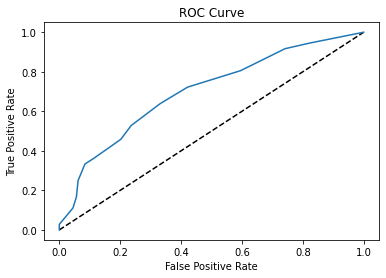

In [ ]:
y_pred_prob = rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred_prob))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Model 2: GaussianNB

In [ ]:
# Criando o classificador logreg
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

In [ ]:
# Printing the Training Score
print("Training score data: ")
print(model.score(X_train, y_train))

Training score data: 
0.7053333333333334


In [ ]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.648
[[124  54]
 [ 34  38]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       178
           1       0.41      0.53      0.46        72

    accuracy                           0.65       250
   macro avg       0.60      0.61      0.60       250
weighted avg       0.68      0.65      0.66       250



0.6598782771535581


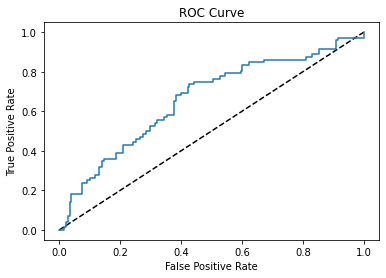

In [ ]:
y_pred_prob = model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred_prob))
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()